# EE379K Final Project
# An Experiment on Speed Dating
### Abigail Johnson, Jeremy Shahan, Raymond Wen, Jacob Williamson

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model as regression
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
%matplotlib inline


In [5]:
"""
Standardizes preference scores to correct collection variations introduced by experiment
From data description : 
Waves 1-5 and 10-21: You have 100 points to distribute among the following attributes -- 
give more points to those attributes that are more important in a potential date, 
and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.
Waves 6-9: Please rate the importance of the following attributes in a potential 
date on a scale of 1-10 (1=not at all important, 10=extremely important): 
"""
def standardize_pref_ratings(df):    
    #print(df.head())
    
    # TODO: gather list of all preference cols
    # pref attributes : pf_o_att, attr_o
    pref_attr = df.filter( regex='attr|sinc|intel|fun|amb|shar' ).columns.tolist() 
    
    # locate rows that have been scaled 1-10 (waves 6 - 10)
    off = df.loc[ df['wave'].isin( range(6,10 ) ) ]
    #print(off.head())
    
    for index, row in off.iterrows():
        row_attr_tot_points = np.sum( [row[pref] for pref in pref_attr ] )
        #print(row_attr_tot_points)
        for pref in pref_attr:
            # scale cell value to relative percentage considering provided preference scores, mult by 100 
            df.loc[index, pref] = ( row[pref] / row_attr_tot_points ) * 100        
    return df

# =========================================================
# Below used as test dataframe for development of above
# =========================================================

d =  {'wave' : pd.Series([ 1, 8, 6, 7 ]) ,
    'attr1_2': pd.Series([25, 2, 1, 5 ]) ,
    'attr4_3': pd.Series([25, 2, 1, 10 ]) ,
    'fun8675309': pd.Series([50, 1, 1, 0 ] )
}

df = pd.DataFrame(d)
df = standardize_pref_ratings(df)

In [6]:
def standarize_lookup(df):    
    #print(df.head())
    
    # TODO: gather list of all preference cols
    # pref attributes : pf_o_att, attr_o
    pref_attr = df.filter( regex='attr_o|inc_o|intel_o|fun_o|amb_o|shar_o' ).columns.tolist() 
    
    # locate rows that have been scaled 1-10 (waves 6 - 10)
    #off = df.loc[ df['wave'].isin( range(6,10 ) ) ]
    #print(off.head())
    
    for index, row in df.iterrows():
        row_attr_tot_points = np.sum( [row[pref] for pref in pref_attr ] )
        #print(row_attr_tot_points)
        for pref in pref_attr:
            # scale cell value to relative percentage considering provided preference scores, mult by 100 
            df.loc[index, pref] = ( row[pref] / row_attr_tot_points ) * 100        
    return df

In [7]:
df = pd.read_csv('data/speed_dating.csv', encoding="ISO-8859-1")
df = df.dropna(axis=1,how="all")
df=standardize_pref_ratings(df)

In [8]:
lookup = pd.DataFrame(index=range(1,553), columns=df.columns.values)

## Creating lookup table

In [9]:
for x in range(1,553):
    lookup.loc[x]['gender']=np.average(df.loc[df["iid"]==x]["gender"])
    lookup.loc[x]['match']=np.average(df.loc[df["iid"]==x]["match"])
    lookup.loc[x]['age']=np.average(df.loc[df["iid"]==x]["age"])
    lookup.loc[x]['career_c']=np.average(df.loc[df["iid"]==x]["career_c"])
    lookup.loc[x]['field_cd']=np.average(df.loc[df["iid"]==x]["field_cd"])
    #lookup.loc[x]['income']=np.average(df.loc[df["iid"]==x]["income"])
    lookup.loc[x]['imprace']=np.average(df.loc[df["iid"]==x]["imprace"])
    lookup.loc[x]['imprelig']=np.average(df.loc[df["iid"]==x]["imprelig"])
    lookup.loc[x]['goal']=np.average(df.loc[df["iid"]==x]["goal"])
    lookup.loc[x]['date']=np.average(df.loc[df["iid"]==x]["date"])
    lookup.loc[x]['go_out']=np.average(df.loc[df["iid"]==x]["go_out"])
    lookup.loc[x]['date']=np.average(df.loc[df["iid"]==x]["date"])
    lookup.loc[x]['sports']=np.average(df.loc[df["iid"]==x]["sports"])
    lookup.loc[x]['tvsports']=np.average(df.loc[df["iid"]==x]["tvsports"])
    lookup.loc[x]['exercise']=np.average(df.loc[df["iid"]==x]["exercise"])
    lookup.loc[x]['museums']=np.average(df.loc[df["iid"]==x]["museums"])
    lookup.loc[x]['dining']=np.average(df.loc[df["iid"]==x]["dining"])
    lookup.loc[x]['art']=np.average(df.loc[df["iid"]==x]["art"])
    lookup.loc[x]['hiking']=np.average(df.loc[df["iid"]==x]["hiking"])
    lookup.loc[x]['gaming']=np.average(df.loc[df["iid"]==x]["gaming"])
    lookup.loc[x]['clubbing']=np.average(df.loc[df["iid"]==x]["clubbing"])
    lookup.loc[x]['reading']=np.average(df.loc[df["iid"]==x]["reading"])
    lookup.loc[x]['tv']=np.average(df.loc[df["iid"]==x]["tv"])
    lookup.loc[x]['theater']=np.average(df.loc[df["iid"]==x]["theater"])
    lookup.loc[x]['movies']=np.average(df.loc[df["iid"]==x]["movies"])
    lookup.loc[x]['concerts']=np.average(df.loc[df["iid"]==x]["concerts"])
    lookup.loc[x]['music']=np.average(df.loc[df["iid"]==x]["music"])
    lookup.loc[x]['shopping']=np.average(df.loc[df["iid"]==x]["shopping"])
    lookup.loc[x]['yoga']=np.average(df.loc[df["iid"]==x]["yoga"])
    lookup.loc[x]['attr3_1']=np.average(df.loc[df["iid"]==x]["attr3_1"])
    lookup.loc[x]['sinc3_1']=np.average(df.loc[df["iid"]==x]["sinc3_1"])
    lookup.loc[x]['intel3_1']=np.average(df.loc[df["iid"]==x]["intel3_1"])
    lookup.loc[x]['fun3_1']=np.average(df.loc[df["iid"]==x]["fun3_1"])
    lookup.loc[x]['amb3_1']=np.average(df.loc[df["iid"]==x]["amb3_1"])
    lookup.loc[x]['attr5_1']=np.average(df.loc[df["iid"]==x]["attr5_1"])
    lookup.loc[x]['sinc5_1']=np.average(df.loc[df["iid"]==x]["sinc5_1"])
    lookup.loc[x]['intel5_1']=np.average(df.loc[df["iid"]==x]["intel5_1"])
    lookup.loc[x]['fun5_1']=np.average(df.loc[df["iid"]==x]["fun5_1"])
    lookup.loc[x]['attr_o']=np.nanmean(df.loc[df["iid"]==x]["attr_o"])
    lookup.loc[x]['sinc_o']=np.nanmean(df.loc[df["iid"]==x]["sinc_o"])
    lookup.loc[x]['intel_o']=np.nanmean(df.loc[df["iid"]==x]["intel_o"])
    lookup.loc[x]['fun_o']=np.nanmean(df.loc[df["iid"]==x]["fun_o"])
    lookup.loc[x]['amb_o']=np.nanmean(df.loc[df["iid"]==x]["amb_o"])
    lookup.loc[x]['shar_o']=np.nanmean(df.loc[df["iid"]==x]["shar_o"])
    lookup.loc[x]['expnum']=np.nanmean(df.loc[df["iid"]==x]["expnum"])
    lookup.loc[x]['dec_o']=np.nanmean(df.loc[df["iid"]==x]["dec_o"])

/Users/rayw512/Anaconda/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/rayw512/Anaconda/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [10]:
lookup["creative_technical"]=np.nan
#lookup.field_cd=lookup.field_cd.astype(int)
for index, row in lookup.iterrows():
    rating=0
    field=row["field_cd"]
    if(field==1):
        rating=14
    elif(field==2):
        rating=18
    elif(field==3):
        rating=6
    elif(field==4):
        rating=15
    elif(field==5):
        rating=17
    elif(field==6):
        rating=3
    elif(field==7):
        rating=7
    elif(field==8):
        rating=13
    elif(field==9):
        rating=9
    elif(field==10):
        rating=18              
    elif(field==11):
        rating=4
    elif(field==12):
        rating=11
    elif(field==13):
        rating=12
    elif(field==14):
        rating=2
    elif(field==15):
        rating=1
    elif(field==16):
        rating=8
    elif(field==17):
        rating=5
    elif(field==18):
        rating=10
    lookup.set_value(index,"creative_technical",rating)

In [11]:
lookup=lookup.dropna(axis=1,how="all")
lookup=lookup.fillna(lookup.mean())
lookup.head()

,gender,match,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,age,field_cd,imprace,imprelig,goal,date,go_out,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,expnum,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,creative_technical
1,0.0,0.4,0.5,6.7,7.4,8.0,7.2,8.000000,7.1,21.0,1.0,2.0,4.0,2.0,7.0,1.0,5.250464,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,2.0,6.0,8.0,8.0,8.0,7.0,6.929936,7.933121,8.257962,7.38535,14.0
2,0.0,0.2,0.6,7.7,7.1,7.9,7.5,7.500000,6.5,24.0,1.0,2.0,5.0,1.0,5.0,1.0,5.250464,3.0,2.0,7.0,10.0,8.0,6.0,3.0,5.0,8.0,10.0,1.0,9.0,8.0,7.0,8.0,3.0,1.0,5.0,7.0,5.0,10.0,8.0,3.0,6.929936,7.933121,8.257962,7.38535,14.0
3,0.0,0.0,0.5,6.5,7.1,7.3,6.2,7.111111,6.0,25.0,2.0,8.0,4.0,6.0,3.0,1.0,5.250464,3.0,8.0,7.0,8.0,5.0,5.0,8.0,4.0,5.0,7.0,8.0,7.0,7.0,7.0,5.0,8.0,7.0,2.0,8.0,9.0,8.0,9.0,8.0,6.929936,7.933121,8.257962,7.38535,18.0
4,0.0,0.2,0.6,7.0,7.1,7.7,7.5,7.700000,7.2,23.0,1.0,1.0,1.0,1.0,5.0,1.0,1.000000,1.0,1.0,6.0,7.0,6.0,7.0,7.0,5.0,7.0,7.0,7.0,9.0,7.0,8.0,7.0,1.0,8.0,2.0,7.0,8.0,9.0,7.0,8.0,6.929936,7.933121,8.257962,7.38535,14.0
5,0.0,0.2,0.3,5.3,7.7,7.6,7.2,7.800000,6.2,21.0,1.0,8.0,1.0,2.0,4.0,1.0,1.000000,7.0,4.0,7.0,7.0,6.0,8.0,6.0,6.0,8.0,6.0,8.0,6.0,6.0,3.0,7.0,8.0,3.0,10.0,6.0,3.0,6.0,10.0,8.0,6.929936,7.933121,8.257962,7.38535,14.0


In [12]:
lookup_men=lookup.loc[lookup["gender"]==1]
lookup_women=lookup.loc[lookup["gender"]==0]
lookup_stand=lookup.copy()
lookup_stand=standarize_lookup(lookup_stand)

## How attributes contribute to match success rate in men and women

In [13]:
y=lookup["dec_o"]
x=lookup[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o","age","field_cd","imprace","imprelig","goal","date","go_out","career_c","sports","tvsports","exercise","dining","museums","art","hiking","gaming","clubbing","reading","tv","theater","movies","concerts","music","shopping","yoga","expnum","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1","attr5_1","sinc5_1","intel5_1","fun5_1","creative_technical"]]  
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
gbr=GradientBoostingRegressor()
gbr.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

### First model with all features

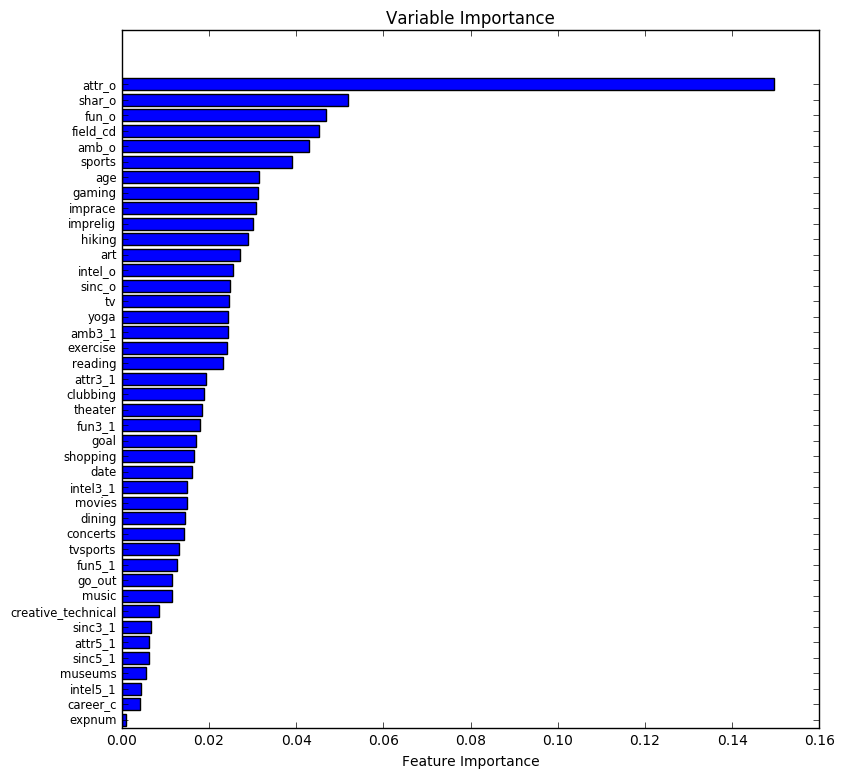

In [14]:
feature_importance = gbr.feature_importances_
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(.5, .5, .5)
plt.figure(figsize=(9,9))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x[sorted_idx],size="small")
plt.xlabel('Feature Importance')
plt.title('Variable Importance')
plt.show()

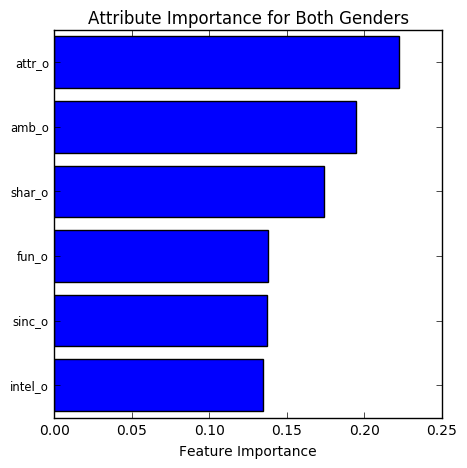

In [15]:
y=lookup["dec_o"]
x=lookup[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o"]]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
gbr=GradientBoostingRegressor()
gbr.fit(x_train,y_train)

feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(5,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x[sorted_idx],size="small")
plt.xlabel('Feature Importance')
plt.title('Attribute Importance for Both Genders')
plt.show()

In [16]:
y=lookup_men["dec_o"]
x=lookup_men[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o"]]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
gbr_m=GradientBoostingRegressor()
gbr_m.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [17]:
y=lookup_women["dec_o"]
x=lookup_women[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o"]]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
gbr_w=GradientBoostingRegressor()
gbr_w.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

### How physical attractiveness effects desirability

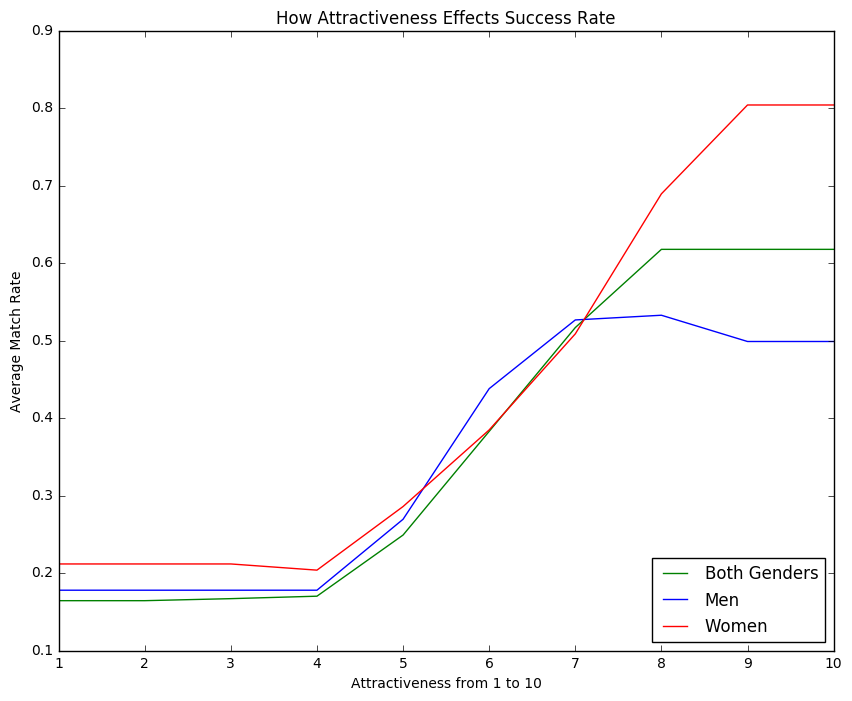

In [32]:
x=[]
y=[]
y_m=[]
y_w=[]
for j in range (1,11):
    avg=0
    for i in range (0,552):
        test_person=lookup[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o"]].iloc[i]
        test_person["attr_o"]=j
        avg=avg+gbr.predict(test_person.reshape(1,-1))[0]
        #print est.predict(test_person)[0]
    y.append(float(avg/552))
    x.append(j)
for j in range (1,11):
    avg=0
    for i in range (0,277):
        test_person=lookup_men[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o"]].iloc[i]
        test_person["attr_o"]=j
        avg=avg+gbr_m.predict(test_person.reshape(1,-1))[0]
        #print est.predict(test_person)[0]
    y_m.append(float(avg/277))
for j in range (1,11):
    avg=0
    for i in range (0,274):
        test_person=lookup_women[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o"]].iloc[i]
        test_person["attr_o"]=j
        avg=avg+gbr_w.predict(test_person.reshape(1,-1))[0]
        #print est.predict(test_person)[0]
    y_w.append(float(avg/274))
plt.title("How Attractiveness Effects Success Rate")
plt.xlabel("Attractiveness from 1 to 10")
plt.ylabel("Average Match Rate")
plt.plot(x,y,label="Both Genders",color='g')
plt.plot(x,y_m,label="Men",color='b')
plt.plot(x,y_w,label="Women",color='r')
plt.legend(loc='lower right')
plt.show()

## How attributes contribute to match success in men

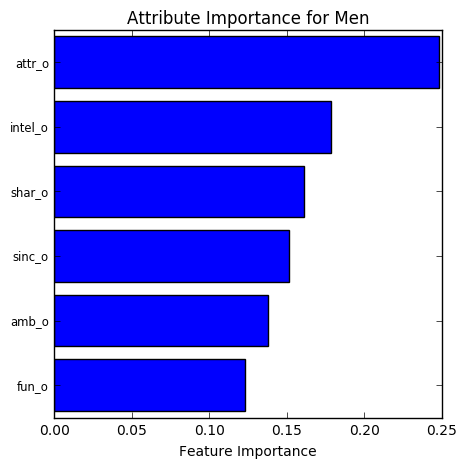

In [19]:
x=lookup[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o",'age']]
feature_importance = gbr_m.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(5,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x[sorted_idx],size="small")
plt.xlabel('Feature Importance')
plt.title('Attribute Importance for Men')
plt.show()

## How attributes contribute to the match success of women

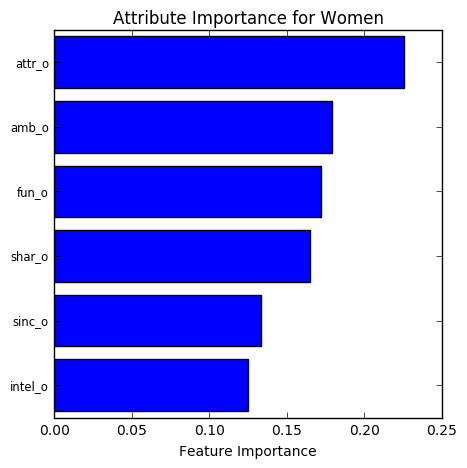

In [20]:
x=lookup[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o",'age']]
feature_importance = gbr_w.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(5,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x[sorted_idx],size="small")
plt.xlabel('Feature Importance')
plt.title('Attribute Importance for Women')
plt.show()

## What determines compatibility?

In [21]:
df=df.fillna(df.mean())

In [22]:
df["attractiveness_diff"]=np.nan
df["age_diff"]=np.nan
df["attribute_diff"]=np.nan
df.pid=df.pid.astype(int)

In [23]:
for index, row in df.iterrows():
    attractivness_diff=abs(lookup.loc[row["iid"]]["attr_o"]-lookup.loc[row["pid"]]["attr_o"])
    age_diff=abs(row["age"]-row["age_o"])
    attribute_diff=np.sqrt((lookup_stand.loc[row["pid"]]["attr_o"]-df.loc[row["pid"]]["pf_o_att"])**2
    +(lookup_stand.loc[row["pid"]]["sinc_o"]-df.loc[row["pid"]]["pf_o_sin"])**2
    +(lookup_stand.loc[row["pid"]]["intel_o"]-df.loc[row["pid"]]["pf_o_int"])**2
    +(lookup_stand.loc[row["pid"]]["fun_o"]-df.loc[row["pid"]]["pf_o_fun"])**2
    +(lookup_stand.loc[row["pid"]]["amb_o"]-df.loc[row["pid"]]["pf_o_amb"])**2
    +(lookup_stand.loc[row["pid"]]["shar_o"]-df.loc[row["pid"]]["pf_o_sha"])**2)

    df.set_value(index,"attractiveness_diff",attractivness_diff)
    df.set_value(index,"age_diff",age_diff)
    df.set_value(index,"attribute_diff",attribute_diff)

In [24]:
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3,attractiveness_diff,age_diff,attribute_diff
0,1,1.0,0,1,1,1,10,7,9.295775,4,1,11,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,5.277791,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,31.999797,12.347121,14.455799,17.931062,10.84266,12.323829,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,6.941908,7.927232,8.284346,7.426213,7.617611,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.000000,2.0,4.0,22.635849,14.4,16.422642,14.092075,9.268868,11.329245,7.082249,7.978959,8.164499,7.612471,7.50153,6.0,2.0,1.0,32.819556,13.529923,15.293851,18.868448,7.286957,12.156028,19.44,16.67,13.89,22.22,11.11,16.67,32.607951,13.502627,13.78387,17.425177,10.274617,12.642221,32.687286,13.158874,13.201295,17.984654,10.83915,12.083368,6.0,7.0,8.0,7.0,6.0,6.827964,7.394106,7.838702,7.279415,7.332191,1.0,1.0,0.0,1.230615,0.934132,15.0,20.0,20.0,15.0,15.0,15.0,31.330357,15.654266,16.679563,16.418155,7.823909,12.207837,33.600198,12.363095,13.688492,17.12996,10.260417,13.195933,32.697917,12.576885,14.229663,18.135913,10.609127,11.96627,5.0,7.0,7.0,7.0,7.0,6.81002,7.615079,7.93254,7.155258,7.048611,1.1,6.0,64.462203
1,1,1.0,0,1,1,1,10,7,9.295775,3,2,12,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,5.277791,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,31.999797,12.347121,14.455799,17.931062,10.84266,12.323829,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,6.941908,7.927232,8.284346,7.426213,7.617611,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.000000,1.0,4.0,22.635849,14.4,16.422642,14.092075,9.268868,11.329245,7.082249,7.978959,8.164499,7.612471,7.50153,6.0,2.0,1.0,32.819556,13.529923,15.293851,18.868448,7.286957,12.156028,19.44,16.67,13.89,22.22,11.11,16.67,32.607951,13.502627,13.78387,17.425177,10.274617,12.642221,32.687286,13.158874,13.201295,17.984654,10.83915,12.083368,6.0,7.0,8.0,7.0,6.0,6.827964,7.394106,7.838702,7.279415,7.332191,1.0,1.0,0.0,1.230615,0.934132,15.0,20.0,20.0,15.0,15.0,15.0,31.330357,15.654266,16.679563,16.418155,7.823909,12.207837,33.600198,12.363095,13.688492,17.12996,10.260417,13.195933,32.697917,12.576885,14.229663,18.135913,10.609127,11.96627,5.0,7.0,7.0,7.0,7.0,6.81002,7.615079,7.93254,7.155258,7.048611,0.4,1.0,5.301978
2,1,1.0,0,1,1,1,10,7,9.295775,10,3,13,1,0.16,1,22.0,4.0

In [25]:
y=df["match"]
x=df[["imprace","imprelig","date","age_diff","go_out","goal","attribute_diff","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1",'shar_o']]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
gb=GradientBoostingClassifier()
gb.fit(x_train,y_train)

prob=gb.predict_proba(x_test)
output=[]
for x in prob:
    output.append(x[1])
print "AUC Score: "+ str(roc_auc_score(y_true=y_test,y_score=output))

AUC Score: 0.724066395246


### Feature importance in compatibility

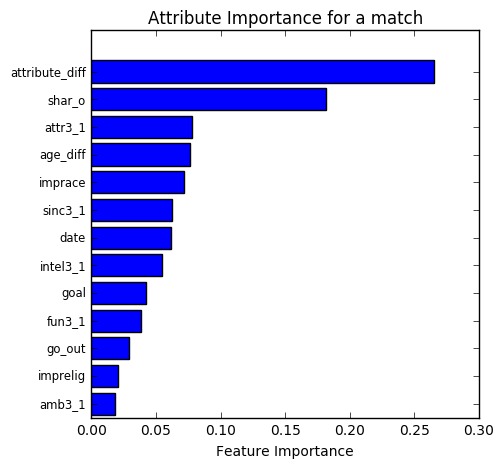

In [26]:
x=df[["imprace","imprelig","date","age_diff","go_out","goal","attribute_diff","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1",'shar_o']]
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(5,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x[sorted_idx],size="small")
plt.xlabel('Feature Importance')
plt.title('Attribute Importance for a match')
plt.show()

In [38]:
y=df["match"]
x=df[["imprace","imprelig","date","age_diff","go_out","goal","attribute_diff","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1",'shar_o',"attractiveness_diff"]]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
gb=GradientBoostingClassifier()
gb.fit(x_train,y_train)

prob=gb.predict_proba(x_test)
output2=[]
for x in prob:
    output2.append(x[1])
print "AUC Score: "+ str(roc_auc_score(y_true=y_test,y_score=output2))

AUC Score: 0.733533512441


## Feature importance in compatibility with attractiveness_diff added

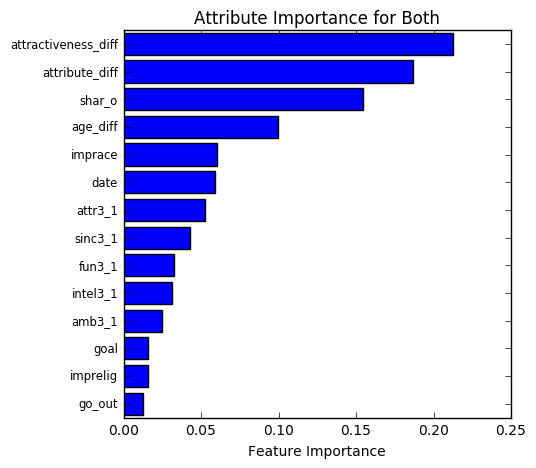

In [39]:
x=df[["imprace","imprelig","date","age_diff","go_out","goal","attribute_diff","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1",'shar_o',"attractiveness_diff"]]
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(5,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x[sorted_idx],size="small")
plt.xlabel('Feature Importance')
plt.title('Attribute Importance for Both')
plt.show()

### AUC Curve plotted with with and without attractiveness_diff

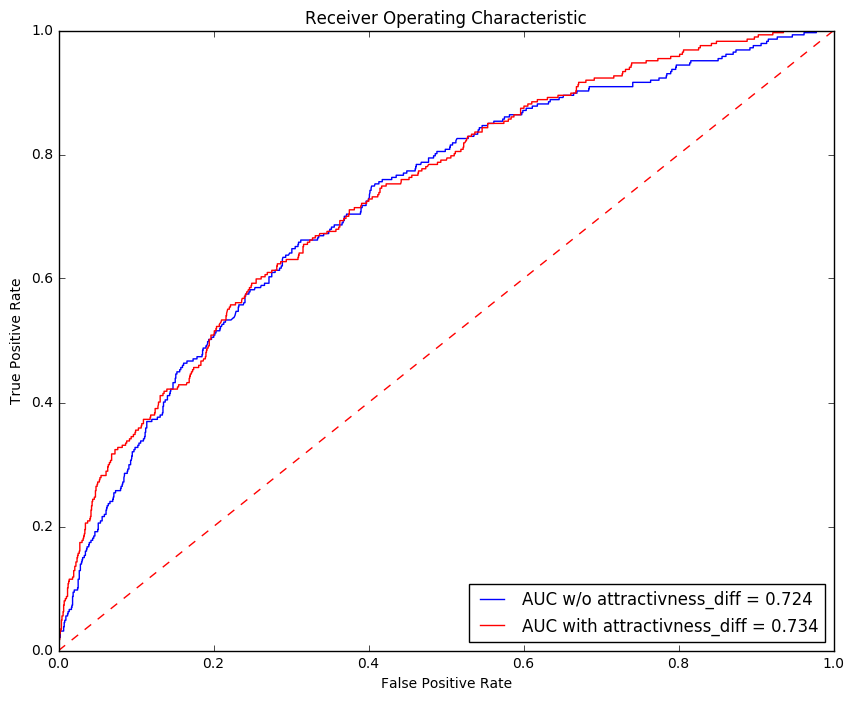

In [40]:
from sklearn.metrics import roc_curve, auc
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 10, 8
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true=y_test,y_score=output)
roc_auc = auc(false_positive_rate, true_positive_rate)

false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_true=y_test,y_score=output2)
roc_auc2 = auc(false_positive_rate2, true_positive_rate2)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC w/o attractivness_diff = %0.3f'% roc_auc)
plt.plot(false_positive_rate2, true_positive_rate2, 'r', label='AUC with attractivness_diff = %0.3f'% roc_auc2)
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Modelling the effect of attractivness_diff on match rate

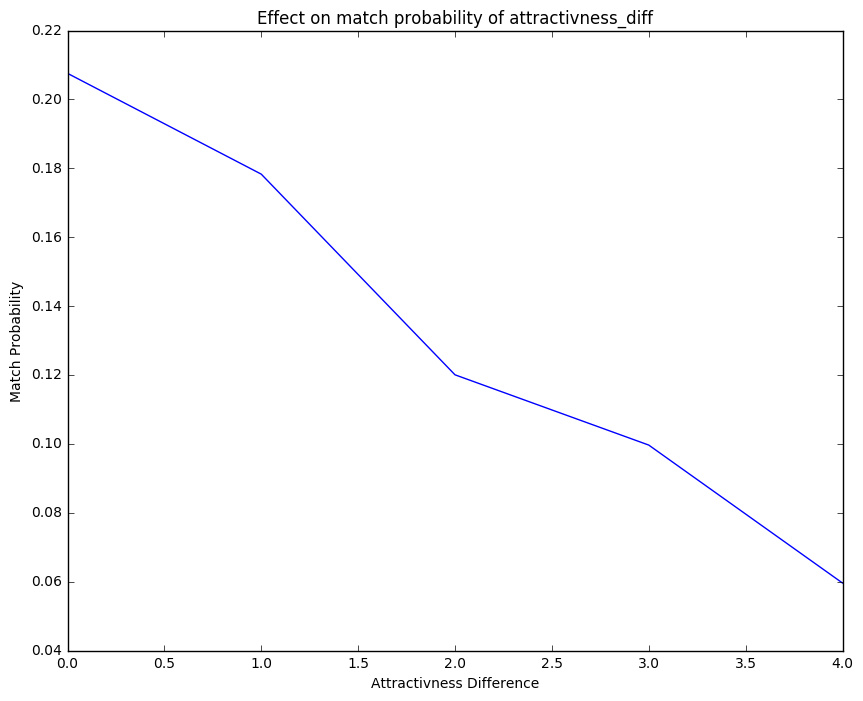

In [30]:
x=[]
y=[]
for j in range (0,5):
    avg=0
    for i in range (0,8377):
        test_person=df[["imprace","imprelig","date","age_diff","go_out","goal","attribute_diff","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1",'shar_o',"attractiveness_diff"]].iloc[i]
        test_person["attractiveness_diff"]=j
        avg=avg+gb.predict_proba(test_person.reshape(1,-1))[0][1]
    y.append(float(avg/8377))
    x.append(j)
plt.title("Effect on match probability of attractivness_diff")
plt.xlabel("Attractivness Difference")
plt.ylabel("Match Probability")
plt.plot(x,y)
plt.show()

### Modelling the effect of attribute_diff on match rate

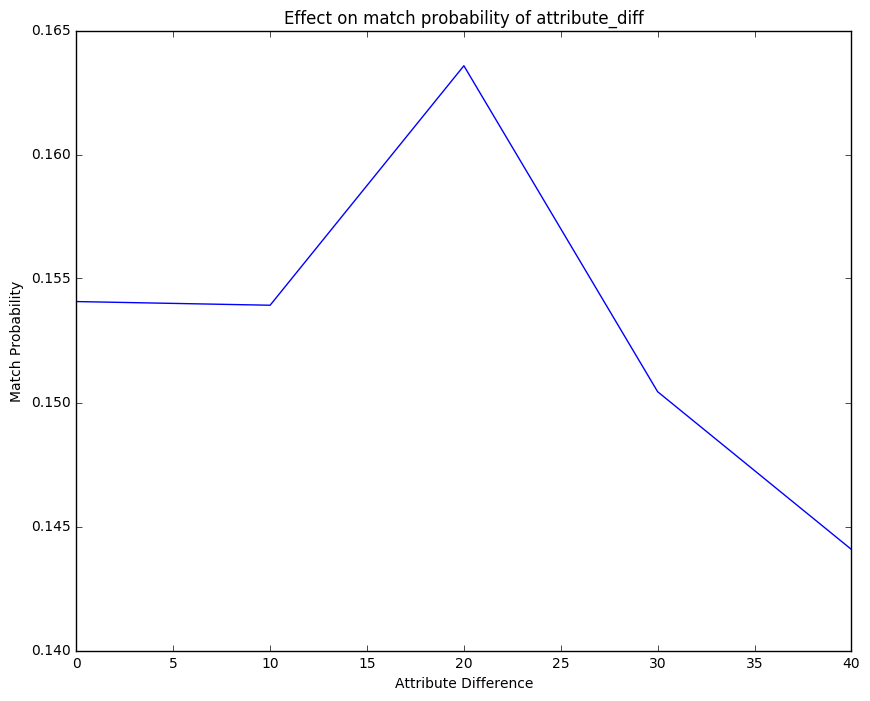

In [41]:
x=[]
y=[]
for j in range (0,5):
    avg=0
    for i in range (0,8377):
        test_person=df[["imprace","imprelig","date","age_diff","go_out","goal","attribute_diff","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1",'shar_o',"attractiveness_diff"]].iloc[i]
        test_person["attribute_diff"]=j*10
        avg=avg+gb.predict_proba(test_person.reshape(1,-1))[0][1]
    y.append(float(avg/8377))
    x.append(j*10)
plt.title("Effect on match probability of attribute_diff")
plt.xlabel("Attribute Difference")
plt.ylabel("Match Probability")
plt.plot(x,y)
plt.show()